In [1]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score, det_curve
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

/home/phucdt/anaconda3/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MaiBui ADV DF set

In [53]:
# load DF 2021 set
DF_df = pd.read_csv("/datab/Dataset/ASVspoof/LA/ASVspoof2021_keys/DF/CM/trial_metadata.txt", sep=" ", header=None)
DF_df.columns = ["sid", "utt","codec", "src", "attack", "label", "trim", "subset","vocoder","b","c","d","e"]

DF_df['utt'] = DF_df['utt'].apply(lambda x: x.split('_')[2])

DF_df

,sid,utt,codec,src,attack,label,trim,subset,vocoder,b,c,d,e
0,LA_0023,2000011,nocodec,asvspoof,A14,spoof,notrim,progress,traditional_vocoder,-,-,-,-
1,TEF2,2000013,low_m4a,vcc2020,Task1-team20,spoof,notrim,eval,neural_vocoder_nonautoregressive,Task1,team20,FF,E
2,TGF1,2000024,mp3m4a,vcc2020,Task2-team12,spoof,notrim,eval,traditional_vocoder,Task2,team12,FF,G
3,LA_0043,2000026,mp3m4a,asvspoof,A09,spoof,notrim,eval,traditional_vocoder,-,-,-,-
4,LA_0021,2000027,mp3m4a,asvspoof,A12,spoof,notrim,eval,neural_vocoder_autoregressive,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
611824,VCC2TM2,4999945,oggm4a,vcc2018,SPO-N16,spoof,notrim,eval,traditional_vocoder,SPO,N16,FM,-
611825,LA_0044,4999962,oggm4a,asvspoof,A19,spoof,trim,hidden,traditional_vocoder,-,-,-,-
611826,LA_0042,4999964,high_ogg,asvspoof,A13,spoof,notrim,eval,traditional_vocoder,-,-,-,-
611827,TEM1,4999980,low_m4a,vcc2020,Task1-team07,spoof,notrim,eval,neural_vocoder_autoregressive,Task1,team07,FM,E


### ifgsm_rm70_1e-08_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt

In [64]:
ori_df = pd.read_csv("docs/df2021_1e-08_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt", sep=" ", header=None)
ori_df.columns = ["utt","spoof","score"]
ori_df['utt'] = ori_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[2])

merge_df = ori_df.merge(pred_df, on="utt", how="inner")
print(len(merge_df))
merge_df['spoof'] = merge_df['spoof_x']
merge_df['score'] = merge_df['score_x']
merge_df['pred'] = merge_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(DF_df, merge_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))

3925
3925
Accuracy: 95.90%
Recall: 95.90%
Precision: 100.00%
F1: 97.91%


3925
3925
3925
Accuracy: 86.11%
Recall: 86.11%
Precision: 100.00%
F1: 92.54%
TP: 3380, TN: 0, FP: 0, FN: 545
TPR: 86.11%
FNR: 13.89%
False Positive
neural_vocoder_autoregressive - 351 - 19.2963%
traditional_vocoder - 123 - 12.4746%
unknown - 24 - 10.3004%
neural_vocoder_nonautoregressive - 30 - 3.8023%
waveform_concatenation - 17 - 17.3469%
False negative
neural_vocoder_autoregressive - 0 - 0.0000%
traditional_vocoder - 0 - 0.0000%
unknown - 0 - 0.0000%
neural_vocoder_nonautoregressive - 0 - 0.0000%
waveform_concatenation - 0 - 0.0000%


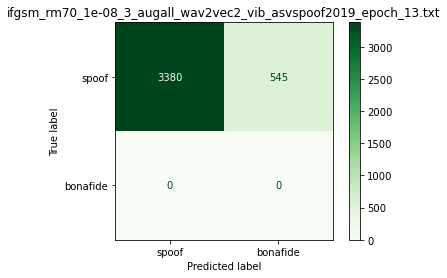

In [59]:
pred_df = pd.read_csv("docs/ifgsm_rm70_1e-08_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[2])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(DF_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("TPR: {:.2f}%".format(cm[0][0]/(cm[0][0]+cm[0][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))
# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'vocoder'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("ifgsm_rm70_1e-08_3_augall_wav2vec2_vib_asvspoof2019_epoch_13.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### ifgsm_rm70_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt

3925
3925
3925
Accuracy: 63.77%
Recall: 63.77%
Precision: 100.00%
F1: 77.88%
TP: 2503, TN: 0, FP: 0, FN: 1422
TPR: 63.77%
FNR: 36.23%
False Positive
neural_vocoder_autoregressive - 686 - 37.7130%
traditional_vocoder - 499 - 50.6085%
unknown - 74 - 31.7597%
neural_vocoder_nonautoregressive - 124 - 15.7161%
waveform_concatenation - 39 - 39.7959%
False negative
neural_vocoder_autoregressive - 0 - 0.0000%
traditional_vocoder - 0 - 0.0000%
unknown - 0 - 0.0000%
neural_vocoder_nonautoregressive - 0 - 0.0000%
waveform_concatenation - 0 - 0.0000%


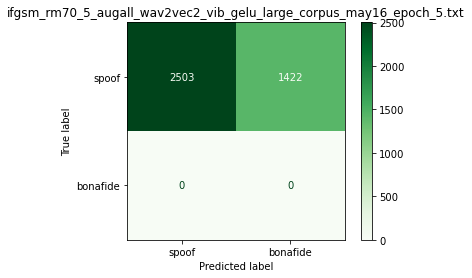

In [57]:
pred_df = pd.read_csv("docs/ifgsm_rm70_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[2])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(DF_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("TPR: {:.2f}%".format(cm[0][0]/(cm[0][0]+cm[0][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))
# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'vocoder'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("ifgsm_rm70_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## MLAAD

In [3]:
mlaad_df = pd.read_csv("../traindata/MLAAD/meta.csv")
# mlaad_df
# print(len(mlaad_df))

### mlaad_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt


74000
74000
74000
Accuracy: 92.5959%


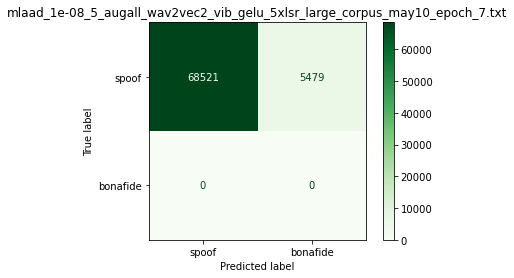

In [4]:
pred_df = pd.read_csv("docs/mlaad_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["path","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['path'])
print(len(pred_df))

# pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(mlaad_df, pred_df, on='path')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("mlaad_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## Fake or real

In [37]:
# load in the wild protocol
for_df = pd.read_csv("../traindata/fake_or_real/protocol.txt", sep=" ", header=None)
for_df.columns = ['utt', 'subset', 'label']
for_df.head

<bound method NDFrame.head of                                                      utt subset     label
0      training/fake/file5419.mp3.wav_16k.wav_norm.wa...  train     spoof
1      validation/fake/file28195.mp3.wav_16k.wav_norm...    dev     spoof
2      training/real/file13228.wav_16k.wav_norm.wav_m...  train  bonafide
3      training/fake/file23499.mp3.wav_16k.wav_norm.w...  train     spoof
4      training/real/file23689.wav_16k.wav_norm.wav_m...  train  bonafide
...                                                  ...    ...       ...
69293  training/fake/file12766.mp3.wav_16k.wav_norm.w...  train     spoof
69294  training/fake/file3454.mp3.wav_16k.wav_norm.wa...  train     spoof
69295  training/real/file16094.wav_16k.wav_norm.wav_m...  train  bonafide
69296  validation/fake/file17612.mp3.wav_16k.wav_norm...    dev     spoof
69297  testing/real/file17.wav_16k.wav_norm.wav_mono....   eval  bonafide

[69298 rows x 3 columns]>

### for_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt

EER: 7.0781%, threshold: -2.1974


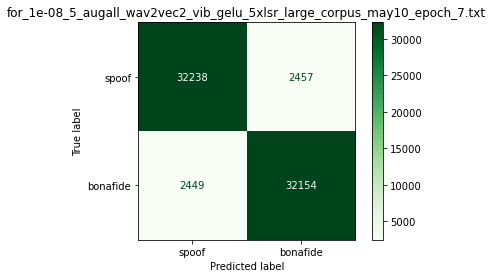

In [38]:
pred_df = pd.read_csv("docs/for_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof", "score"]

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(for_df, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("for_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## Voice Phishing

In [4]:
# load in the wild protocol
vp_df = pd.read_csv("/datab/Dataset/intern_2024_jan31/voice_phishing_dataset/protocol.txt", sep=" ", header=None)
vp_df.columns = ['path', 'subset', 'cate', 'label']
vp_df['label'].value_counts()
vp_df.head

# vp_df['utt'] = vp_df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])


<bound method NDFrame.head of                                  path subset cate     label
0     ./금감원_180711/금감원_180711_3_3.wav   eval    -  bonafide
1     ./금감원_180711/금감원_180711_8_3.wav   eval    -  bonafide
2    ./금감원_180711/금감원_180711_16_2.wav   eval    -  bonafide
3     ./금감원_180711/금감원_180711_4_2.wav   eval    -  bonafide
4     ./금감원_180711/금감원_180711_5_1.wav   eval    -  bonafide
..                                ...    ...  ...       ...
453   ./금감원_210513/금감원_210513_1_5.wav   eval    -  bonafide
454   ./금감원_210513/금감원_210513_1_3.wav   eval    -  bonafide
455   ./금감원_210513/금감원_210513_1_4.wav   eval    -  bonafide
456   ./금감원_210513/금감원_210513_1_2.wav   eval    -  bonafide
457   ./금감원_210513/금감원_210513_1_1.wav   eval    -  bonafide

[458 rows x 4 columns]>

### voicephishing_large_corpus_epoch15_lora1_phone_epoch11.txt

Accuracy: 85.175879


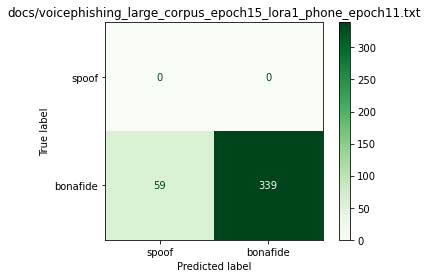

In [8]:
pred_df = pd.read_csv("docs/voicephishing_large_corpus_epoch15_lora1_phone_epoch11.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof", "score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[-1].split('_')[-3])
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[1].split('_')[1])
pred_df=pred_df[pred_df['date']<'220101']
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(vp_df, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/voicephishing_large_corpus_epoch15_lora1_phone_epoch11.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### vphishing_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt

Accuracy: 93.216080


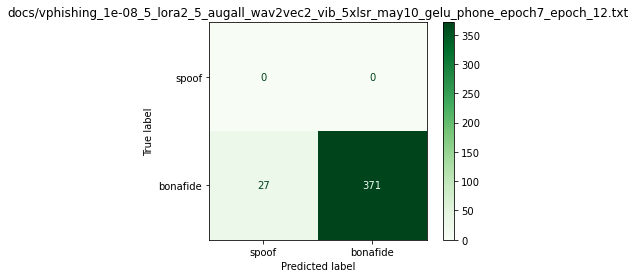

In [5]:
pred_df = pd.read_csv("docs/vphishing_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof", "score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[-1].split('_')[-3])
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[1].split('_')[1])
pred_df=pred_df[pred_df['date']<'220101']
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(vp_df, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/vphishing_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

Accuracy: 76.633166


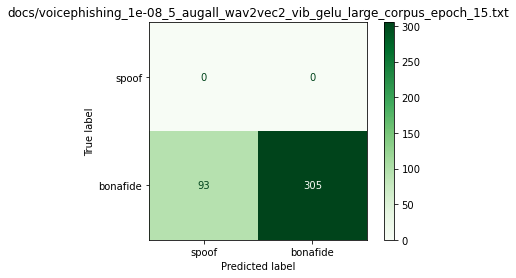

In [20]:
pred_df = pd.read_csv("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof", "score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[-1].split('_')[-3])
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[1].split('_')[1])
pred_df=pred_df[pred_df['date']<'220101']
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(vp_df, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [19]:
# pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[1].split('_')[1])
pred_df


,path,spoof,score,date,pred
160,./금감원_231006/금감원_보이스피싱_6_2.wav,-8.359336,-0.000234,231006,bonafide
161,./금감원_231006/금감원_보이스피싱_4_5.wav,-0.000248,-8.304127,231006,spoof
162,./금감원_231006/금감원_보이스피싱_12_2.wav,-7.773460,-0.000421,231006,bonafide
163,./금감원_231006/금감원_보이스피싱_9_5.wav,-8.063279,-0.000315,231006,bonafide
164,./금감원_231006/금감원_보이스피싱_11_2.wav,-8.402637,-0.000224,231006,bonafide
165,./금감원_231006/금감원_보이스피싱_6_1.wav,-8.366073,-0.000233,231006,bonafide
166,./금감원_231006/금감원_보이스피싱_2_4.wav,-7.764064,-0.000425,231006,bonafide
167,./금감원_231006/금감원_보이스피싱_12_3.wav,-0.012419,-4.394735,231006,spoof
168,./금감원_231006/금감원_보이스피싱_8_2.wav,-8.381670,-0.000229,231006,bonafide
169,./금감원_231006/금감원_보이스피싱_10_5.wav,-8.381545,-0.000229,231006,bonafide


### voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_acmccs_apr3_more_ko_telephone_epoch_22.txt

Accuracy: 47.598253


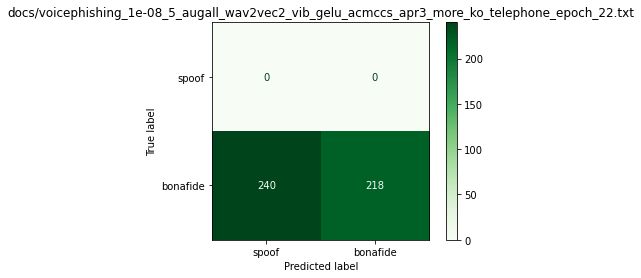

In [17]:
pred_df = pd.read_csv("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_acmccs_apr3_more_ko_telephone_epoch_22.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof", "score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(vp_df, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_acmccs_apr3_more_ko_telephone_epoch_22.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## 1-phone

In [25]:
# load in the wild protocol
phonedf = pd.read_csv("/datab/Dataset/cnsl_real_fake_audio/1-phone_large-corpus/protocol.txt", sep=" ", header=None)
phonedf.columns = ['path', 'subset',"asdf", 'label']
phonedf['label'].value_counts()
phonedf.head

# vp_df['utt'] = vp_df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])


<bound method NDFrame.head of                                                path subset asdf     label
0                       ./normal/금감원_160518_4_5.wav  train    -  bonafide
1                       ./normal/금감원_160406_1_1.wav  train    -  bonafide
2                       ./normal/금감원_210504_6_2.wav  train    -  bonafide
3                      ./normal/금감원_200106_10_1.wav  train    -  bonafide
4                       ./normal/금감원_180711_6_4.wav  train    -  bonafide
...                                             ...    ...  ...       ...
1827  ./vocoded/hn-sinc-nsf-hifi/금감원_160518_1_5.wav   eval    -     spoof
1828  ./vocoded/hn-sinc-nsf-hifi/금감원_170104_3_2.wav   eval    -     spoof
1829  ./vocoded/hn-sinc-nsf-hifi/금감원_200106_7_2.wav   eval    -     spoof
1830  ./vocoded/hn-sinc-nsf-hifi/금감원_150828_1_4.wav   eval    -     spoof
1831  ./vocoded/hn-sinc-nsf-hifi/금감원_170104_5_4.wav   eval    -     spoof

[1832 rows x 4 columns]>

### 1-phone_lora3_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch5_epoch_5.txt

Accuracy: 94.021739%
F1: 48.459384%


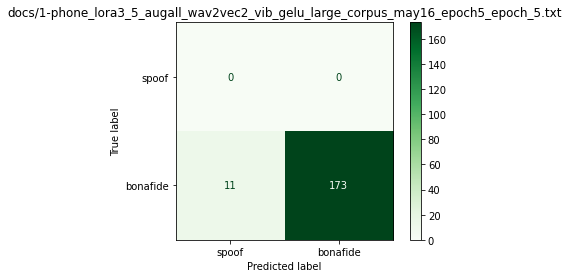

In [26]:
pred_df = pd.read_csv("docs/1-phone_lora3_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch5_epoch_5.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/1-phone_lora3_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch5_epoch_5.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
print("F1: {:2f}%".format(f1_score(res_df["label"], res_df["pred"], average='macro')*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### 1-phone_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt

Accuracy: 91.847826%
F1: 47.875354%


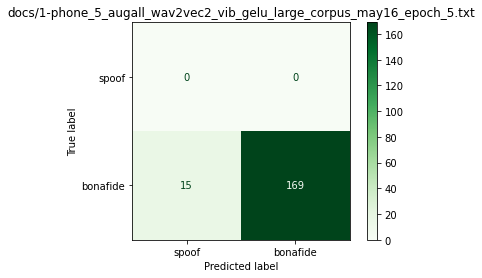

In [10]:
pred_df = pd.read_csv("docs/1-phone_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/1-phone_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
print("F1: {:2f}%".format(f1_score(res_df["label"], res_df["pred"], average='macro')*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### 1-phone_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_7.txt

Accuracy: 94.021739%
F1: 48.459384%


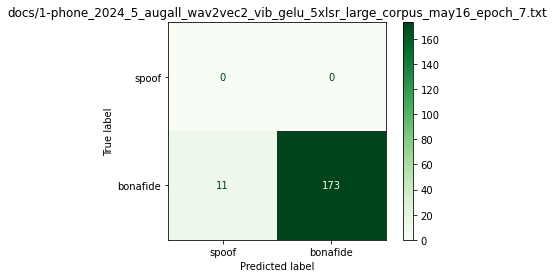

In [8]:
pred_df = pd.read_csv("docs/1-phone_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/1-phone_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_7.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
print("F1: {:2f}%".format(f1_score(res_df["label"], res_df["pred"], average='macro')*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### 1-phone_lora_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_regex_epoch_11.txt

Accuracy: 90.217391%
F1: 47.428571%


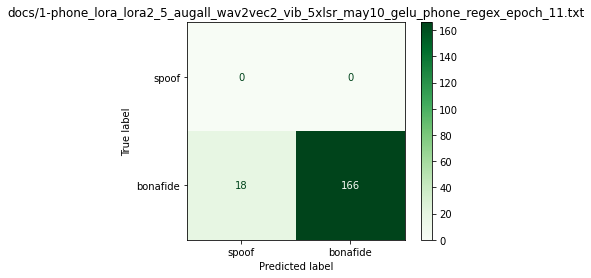

In [23]:
pred_df = pd.read_csv("docs/1-phone_lora_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_regex_epoch_11.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/1-phone_lora_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_regex_epoch_11.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
print("F1: {:2f}%".format(f1_score(res_df["label"], res_df["pred"], average='macro')*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [24]:
regex_list = res_df[res_df["label"] != res_df["pred"]]['path']

### 1-phone_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt

Accuracy: 90.217391%
F1: 47.428571%


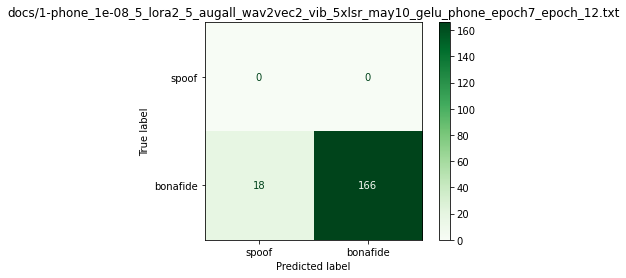

In [25]:
pred_df = pd.read_csv("docs/1-phone_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/1-phone_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
print("F1: {:2f}%".format(f1_score(res_df["label"], res_df["pred"], average='macro')*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [26]:
th5_list = res_df[res_df["label"] != res_df["pred"]]['path']

In [27]:
regex_list == th5_list

3      True
6      True
7      True
16     True
40     True
44     True
52     True
57     True
58     True
89     True
98     True
103    True
116    True
150    True
153    True
157    True
158    True
169    True
Name: path, dtype: bool

In [31]:
os.makedirs("/datab/Dataset/cnsl_real_fake_audio/1-phone_large-corpus/regex_misclassified/", exist_ok=True)
for f in th5_list:
    print(f)
    shutil.copy('/datab/Dataset/cnsl_real_fake_audio/1-phone_large-corpus/'+f, "/datab/Dataset/cnsl_real_fake_audio/1-phone_large-corpus/regex_misclassified/")

./normal/금감원_보이스피싱_4_5.wav
./normal/금감원_200106_1_3.wav
./normal/금감원_210506_1_3.wav
./normal/금감원_200106_13_2.wav
./normal/금감원_160518_8_4.wav
./normal/금감원_160518_4_1.wav
./normal/금감원_200106_1_2.wav
./normal/금감원_보이스피싱_7_1.wav
./normal/금감원_200106_7_4.wav
./normal/금감원_보이스피싱_4_1.wav
./normal/금감원_보이스피싱_9_2.wav
./normal/금감원_161109_3_4.wav
./normal/금감원_161109_3_2.wav
./normal/금감원_보이스피싱_12_4.wav
./normal/금감원_160518_9_1.wav
./normal/금감원_161109_5_3.wav
./normal/금감원_보이스피싱_4_3.wav
./normal/금감원_160518_4_4.wav


### 1-phone_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt

Accuracy: 86.899563%
F1: 46.495327%


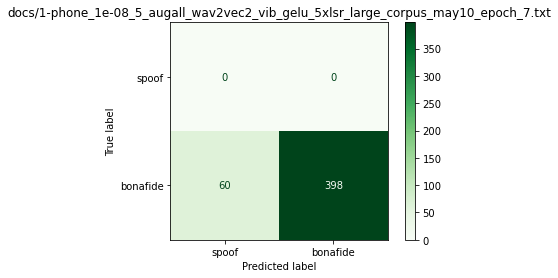

In [14]:
pred_df = pd.read_csv("docs/1-phone_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/1-phone_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
print("F1: {:2f}%".format(f1_score(res_df["label"], res_df["pred"], average='macro')*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [15]:
res_df[res_df["label"] != res_df["pred"]]

,path,subset,asdf,label,spoof,score,pred
0,./normal/금감원_160518_4_5.wav,train,-,bonafide,-0.155417,-1.938344,spoof
10,./normal/금감원_160518_9_2.wav,train,-,bonafide,-0.001047,-6.862762,spoof
19,./normal/금감원_160518_8_1.wav,train,-,bonafide,-0.161544,-1.902661,spoof
29,./normal/금감원_160518_8_3.wav,train,-,bonafide,-0.021335,-3.858066,spoof
34,./normal/금감원_보이스피싱_12_1.wav,train,-,bonafide,-0.007137,-4.946020,spoof
38,./normal/금감원_161109_3_5.wav,train,-,bonafide,-0.008581,-4.762448,spoof
52,./normal/금감원_보이스피싱_1_1.wav,train,-,bonafide,-0.077009,-2.602095,spoof
72,./normal/금감원_200106_1_4.wav,train,-,bonafide,-0.179705,-1.804945,spoof
75,./normal/금감원_보이스피싱_4_4.wav,train,-,bonafide,-0.000945,-6.965352,spoof
82,./normal/금감원_보이스피싱_2_5.wav,train,-,bonafide,-0.145255,-2.001015,spoof


### phone_large_corpus_epoch15_lora1_phone_epoch11.txt

Accuracy: 85.869565%


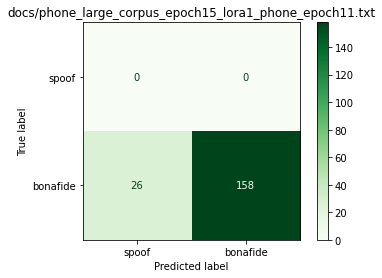

In [19]:
pred_df = pd.read_csv("docs/phone_large_corpus_epoch15_lora1_phone_epoch11.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/phone_large_corpus_epoch15_lora1_phone_epoch11.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### docs/test_lora.txt

Accuracy: 94.414169


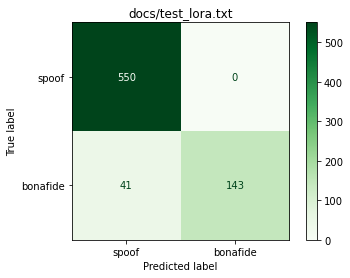

In [10]:
pred_df = pd.read_csv("docs/test_lora.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/test_lora.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### phone_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

Accuracy: 78.532609%


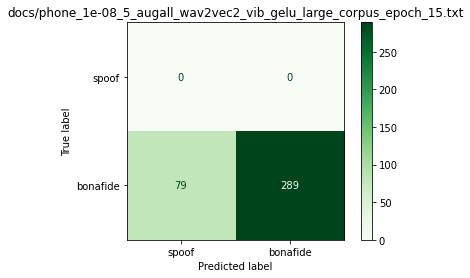

In [18]:
pred_df = pd.read_csv("docs/phone_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof","score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(phonedf, pred_df, on='path')
res_df=res_df[res_df['label']=='bonafide']
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/phone_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
print("Accuracy: {:2f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## InWild

In [2]:
# load in the wild protocol
in_the_wild = pd.read_csv("../traindata/in_the_wild/protocol.txt", sep=" ", header=None)
in_the_wild.columns = ['utt', 'subset', 'label']
in_the_wild['label'].value_counts()
in_the_wild.head


<bound method NDFrame.head of                  utt subset     label
0          wav/1.wav   eval     spoof
1          wav/2.wav   eval     spoof
2          wav/3.wav   eval     spoof
3          wav/4.wav   eval  bonafide
4          wav/5.wav   eval  bonafide
...              ...    ...       ...
31773  wav/31774.wav   eval  bonafide
31774  wav/31775.wav   eval  bonafide
31775  wav/31776.wav   eval  bonafide
31776  wav/31777.wav   eval  bonafide
31777  wav/31778.wav   eval     spoof

[31778 rows x 3 columns]>

### /dataa/phucdt/vocodetect/Supcon-voco/docs/Inwild_aasistssl_acmccs_epoch22.txt

EER: 12.5088%, threshold: 1.9117


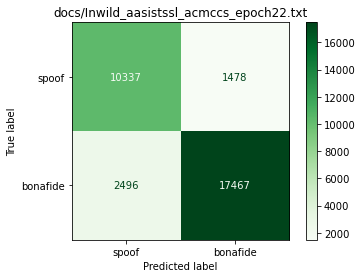

In [5]:
pred_df = pd.read_csv("docs/Inwild_aasistssl_acmccs_epoch22.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]
pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(in_the_wild, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/Inwild_aasistssl_acmccs_epoch22.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## Intern 2024

In [2]:
intern24_df = pd.read_csv("../traindata/intern_2024/metadata_jan30.csv")
intern24_df.fillna("-", inplace=True)
intern24_df = intern24_df.astype(str)
# print(intern24_df.head)
intern24_df['source_group'] = intern24_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
intern24_df['source_group'] = intern24_df['source_group'].apply(lambda x: 'www.youtube.com' if (x == 'youtu.be' or x == 'youtube.com') else x)

### intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_2s_may27_epoch_10.txt

812
812
812
Accuracy: 96.55%
Recall: 95.32%
Precision: 99.62%
F1: 97.42%
TP: 529, TN: 255, FP: 2, FN: 26
FPR: 0.78%
FNR: 4.68%
EER: 2.8033%, threshold: -0.0011
Max, Min score:  -0.0004191712068859 -7.756234169006348
False Positive
www.youtube.com - 0 - 0.0000%
elevenlabs.io - 7 - 4.2683%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 2 - 40.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 3 - 42.8571%
jik876.github.io - 4 - 40.0000%
huggingface.co - 0 - 0.0000%
github.com - 1 - 0.8264%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 7 - 2.1021%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000

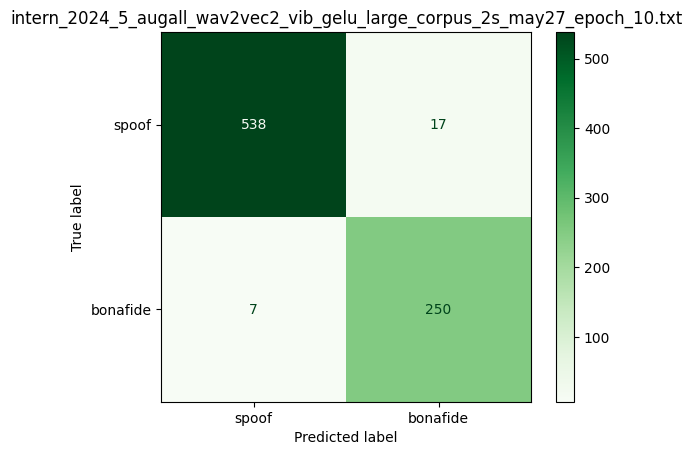

In [3]:
pred_df = pd.read_csv("docs/intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_2s_may27_epoch_10.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("FPR: {:.2f}%".format(cm[1][0]/(cm[1][0]+cm[1][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))

# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_2s_may27_epoch_10.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_2s_may27_epoch_6.txt

812
812
812
Accuracy: 97.41%
Recall: 96.58%
Precision: 99.63%
F1: 98.08%
TP: 536, TN: 255, FP: 2, FN: 19
FPR: 0.78%
FNR: 3.42%
EER: 2.3385%, threshold: -0.1530
Max, Min score:  -0.0006993946735747 -7.194324016571045
False Positive
www.youtube.com - 2 - 0.6006%
elevenlabs.io - 7 - 4.2683%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 1 - 20.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 3 - 30.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 5 - 1.5015%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%

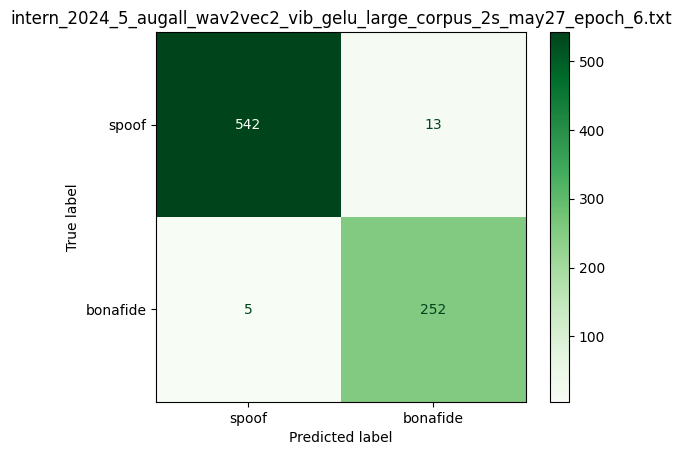

In [3]:
pred_df = pd.read_csv("docs/intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_2s_may27_epoch_6.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("FPR: {:.2f}%".format(cm[1][0]/(cm[1][0]+cm[1][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))

# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_2s_may27_epoch_6.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_14.txt

812
812
812
Accuracy: 91.63%
Recall: 88.65%
Precision: 98.99%
F1: 93.54%
TP: 492, TN: 252, FP: 5, FN: 63
FPR: 1.95%
FNR: 11.35%
EER: 6.1759%, threshold: -0.0005
Max, Min score:  -0.000194173073396 -8.496817588806152
False Positive
www.youtube.com - 1 - 0.3003%
elevenlabs.io - 11 - 6.7073%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 2 - 13.3333%
webapp.dubverse.ai - 5 - 41.6667%
grad-tts.github.io - 4 - 80.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 6 - 85.7143%
jik876.github.io - 4 - 40.0000%
huggingface.co - 1 - 1.1494%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 15 - 4.5045%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.

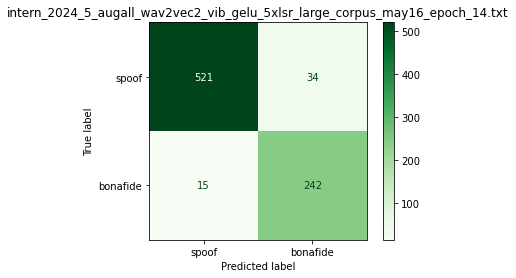

In [66]:
pred_df = pd.read_csv("docs/intern_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_14.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("FPR: {:.2f}%".format(cm[1][0]/(cm[1][0]+cm[1][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))

# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_14.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern2024_1e-08_5_augall_wav2vec2_linear_supcon_feb07_from_nov22_r__29_36_epoch_46.txt

812
812
812
Accuracy: 96.92%
Recall: 97.12%
Precision: 98.36%
F1: 97.73%
TP: 539, TN: 248, FP: 9, FN: 16
FPR: 3.50%
FNR: 2.88%
EER: 3.0880%, threshold: -0.8794
Max, Min score:  -0.0004437177267391 -7.411854267120361
False Positive
www.youtube.com - 5 - 1.5015%
elevenlabs.io - 9 - 5.4878%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 4 - 4.5977%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 8 - 2.4024%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
g

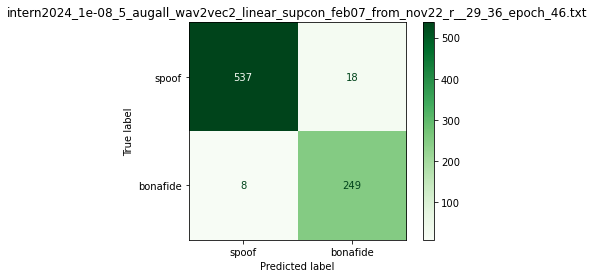

In [50]:
pred_df = pd.read_csv("docs/intern2024_1e-08_5_augall_wav2vec2_linear_supcon_feb07_from_nov22_r__29_36_epoch_46.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("FPR: {:.2f}%".format(cm[1][0]/(cm[1][0]+cm[1][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))

# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern2024_1e-08_5_augall_wav2vec2_linear_supcon_feb07_from_nov22_r__29_36_epoch_46.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_lora3_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch5_epoch_5.txt

812
812
812
Accuracy: 97.91%
Recall: 98.02%
Precision: 98.91%
F1: 98.46%
TP: 544, TN: 251, FP: 6, FN: 11
EER: 2.2484%, threshold: -0.9253
Max, Min score:  -0.0004027270770166 -6.120738983154297
False Positive
www.youtube.com - 0 - 0.0000%
elevenlabs.io - 6 - 3.6585%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 1 - 9.0909%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 1 - 20.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 1 - 14.2857%
jik876.github.io - 3 - 30.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 5 - 1.5015%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0

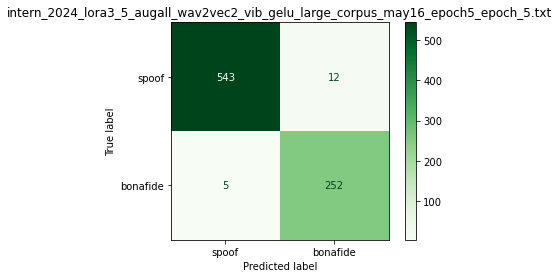

In [40]:
pred_df = pd.read_csv("docs/intern_2024_lora3_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch5_epoch_5.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_lora3_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch5_epoch_5.txt")
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt

812
812
812
Accuracy: 98.15%
Recall: 98.38%
Precision: 98.91%
F1: 98.64%
TP: 546, TN: 251, FP: 6, FN: 9
TPR: 98.38%
FNR: 1.62%
EER: 2.2484%, threshold: -2.7230
Max, Min score:  -0.0006662771338596 -7.409653186798096
False Positive
www.youtube.com - 0 - 0.0000%
elevenlabs.io - 5 - 3.0488%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 1 - 9.0909%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 2 - 40.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 1 - 14.2857%
jik876.github.io - 3 - 30.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 5 - 1.5015%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000

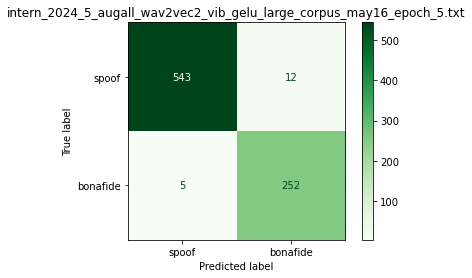

In [51]:
pred_df = pd.read_csv("docs/intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("TPR: {:.2f}%".format(cm[0][0]/(cm[0][0]+cm[0][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))
# merge eval_df and pred_df on utt

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_7.txt

Mean score, Min score, Max score:  -4.577801270133323 -7.633885860443115 -0.0004791065584868
EER: 5.4264%, threshold: -0.1118
False Positive
www.youtube.com - 2 - 0.6006%
elevenlabs.io - 11 - 6.7073%
studio.neiro.ai - 1 - 14.2857%
www.facebook.com - 2 - 18.1818%
app.resemble.ai - 1 - 6.6667%
webapp.dubverse.ai - 4 - 33.3333%
grad-tts.github.io - 2 - 40.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 3 - 42.8571%
jik876.github.io - 4 - 40.0000%
huggingface.co - 0 - 0.0000%
github.com - 1 - 0.8264%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 14 - 4.2042%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
Ac

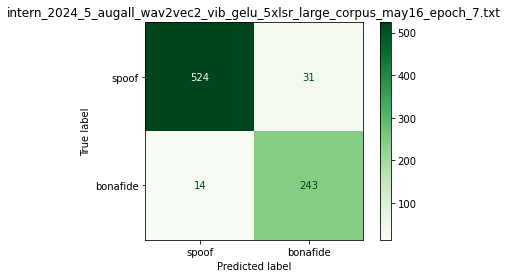

In [6]:
pred_df = pd.read_csv("docs/intern_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]

pred_df.drop_duplicates(subset=['utt'], inplace=True)
# supcon_nov22_finetune_df['utt'] = supcon_nov22_finetune_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Mean score, Min score, Max score: ", pred_df['score'].mean(), pred_df['score'].min(), pred_df['score'].max())
# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(intern24_df, pred_df, on='utt')
# res_df = res_df[res_df['group'] == 'internOct24']
# filter = res_df[res_df['group']=='inthewild_spoof']
# bona = res_df[res_df['group']=='inthewild_bona']
# bona = res_df[(res_df['label'] == 'bonafide')].sample(n=filter.shape[0], random_state=42)
# res_df = pd.concat([filter, bona])

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


print("False Positive")
group_name = "source_group"
groups = res_df[group_name].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may16_epoch_7.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt

Mean score, Min score, Max score:  -4.426818323344006 -7.19249439239502 -0.0004853024438489
EER: 7.3902%, threshold: -2.1125
False Positive
www.youtube.com - 6 - 1.8018%
elevenlabs.io - 14 - 8.5366%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 4 - 33.3333%
grad-tts.github.io - 4 - 80.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 5 - 71.4286%
jik876.github.io - 5 - 50.0000%
huggingface.co - 1 - 1.1494%
github.com - 3 - 2.4793%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 19 - 5.7057%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
Accur

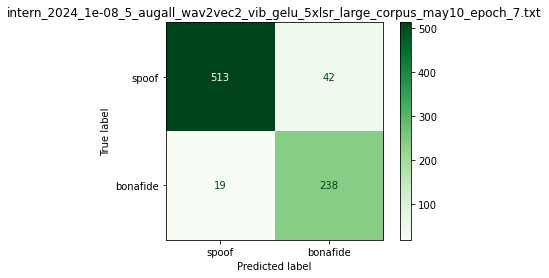

In [4]:
pred_df = pd.read_csv("docs/intern_2024_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]

pred_df.drop_duplicates(subset=['utt'], inplace=True)
# supcon_nov22_finetune_df['utt'] = supcon_nov22_finetune_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Mean score, Min score, Max score: ", pred_df['score'].mean(), pred_df['score'].min(), pred_df['score'].max())
# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(intern24_df, pred_df, on='utt')
# res_df = res_df[res_df['group'] == 'internOct24']
# filter = res_df[res_df['group']=='inthewild_spoof']
# bona = res_df[res_df['group']=='inthewild_bona']
# bona = res_df[(res_df['label'] == 'bonafide')].sample(n=filter.shape[0], random_state=42)
# res_df = pd.concat([filter, bona])

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


print("False Positive")
group_name = "source_group"
groups = res_df[group_name].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### /AISRC1/hungdx/SSL_Anti-spoofing/models/model_DF_weighted_CCE_100_32_1e-06_ACMCCS_0_large_copus_vocoded/trainset_ACMCCS_Intern2024_best_checkpoint_88.txt

Mean score, Min score, Max score:  -1.2052036736555067 -5.133522033691406 3.5958168506622314
EER: 7.0155%, threshold: -0.1780
False Positive
www.youtube.com - 18 - 5.4054%
elevenlabs.io - 17 - 10.3659%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 1 - 9.0909%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 2 - 2.2989%
github.com - 1 - 0.8264%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 17 - 5.1051%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
Accura

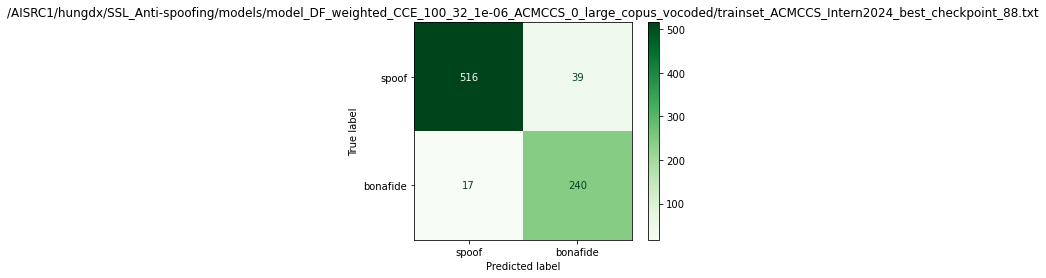

In [4]:
pred_df = pd.read_csv("/AISRC1/hungdx/SSL_Anti-spoofing/models/model_DF_weighted_CCE_100_32_1e-06_ACMCCS_0_large_copus_vocoded/trainset_ACMCCS_Intern2024_best_checkpoint_88.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof", "score"]

pred_df.drop_duplicates(subset=['utt'], inplace=True)
# supcon_nov22_finetune_df['utt'] = supcon_nov22_finetune_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Mean score, Min score, Max score: ", pred_df['score'].mean(), pred_df['score'].min(), pred_df['score'].max())
# if spoof < score, then bonafide, else spoof
# pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(intern24_df, pred_df, on='utt')
# res_df = res_df[res_df['group'] == 'internOct24']
# filter = res_df[res_df['group']=='inthewild_spoof']
# bona = res_df[res_df['group']=='inthewild_bona']
# bona = res_df[(res_df['label'] == 'bonafide')].sample(n=filter.shape[0], random_state=42)
# res_df = pd.concat([filter, bona])

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


print("False Positive")
group_name = "source_group"
groups = res_df[group_name].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("/AISRC1/hungdx/SSL_Anti-spoofing/models/model_DF_weighted_CCE_100_32_1e-06_ACMCCS_0_large_copus_vocoded/trainset_ACMCCS_Intern2024_best_checkpoint_88.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern_2024_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt

Mean score, Min score, Max score:  -4.6407202269002825 -7.425731658935547 -0.0018850667402148
EER: 8.9792%, threshold: -3.7732
False Positive
www.youtube.com - 5 - 1.5015%
elevenlabs.io - 13 - 7.9268%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 2 - 16.6667%
grad-tts.github.io - 5 - 100.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 7 - 100.0000%
jik876.github.io - 8 - 80.0000%
huggingface.co - 5 - 5.7471%
github.com - 5 - 4.1322%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 22 - 6.6066%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
A

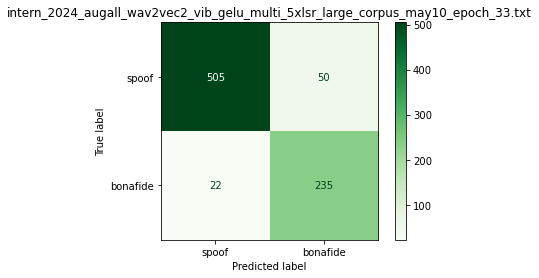

In [4]:
pred_df = pd.read_csv("docs/intern_2024_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]

pred_df.drop_duplicates(subset=['utt'], inplace=True)
# supcon_nov22_finetune_df['utt'] = supcon_nov22_finetune_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Mean score, Min score, Max score: ", pred_df['score'].mean(), pred_df['score'].min(), pred_df['score'].max())
# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(intern24_df, pred_df, on='utt')
# res_df = res_df[res_df['group'] == 'internOct24']
# filter = res_df[res_df['group']=='inthewild_spoof']
# bona = res_df[res_df['group']=='inthewild_bona']
# bona = res_df[(res_df['label'] == 'bonafide')].sample(n=filter.shape[0], random_state=42)
# res_df = pd.concat([filter, bona])

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


print("False Positive")
group_name = "source_group"
groups = res_df[group_name].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern_2024_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### intern2024_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

812
812
812
Accuracy: 97.54%
Recall: 97.66%
Precision: 98.72%
F1: 98.19%
TP: 542, TN: 250, FP: 7, FN: 13
FPR: 2.72%
FNR: 2.34%
EER: 2.7132%, threshold: -6.3008
Max, Min score:  -0.0002074026560876 -8.452096939086914
False Positive
www.youtube.com - 7 - 2.1021%
elevenlabs.io - 8 - 4.8780%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 6 - 1.8018%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
g

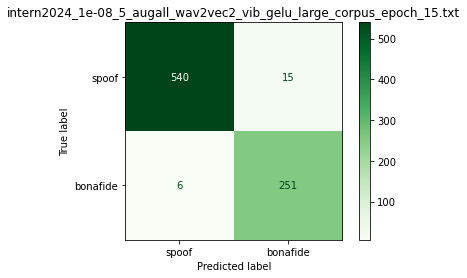

In [49]:
pred_df = pd.read_csv("docs/intern2024_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
res_df = pd.merge(intern24_df, pred_df, on='utt')
print(len(res_df))
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))
print("FPR: {:.2f}%".format(cm[1][0]/(cm[1][0]+cm[1][1])*100))
print("FNR: {:.2f}%".format(cm[0][1]/(cm[0][1]+cm[0][0])*100))

# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'source_group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern2024_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [5]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide')]

,utt,Utterence name (file name),Speaker name,Is multi-speaker?,Language,Gender,Noise type 1,Age,Source link,label,path,Model,Noise Type,source_group,spoof,score,pred
262,TTS_Kim_joo_ha_6,TTS_Kim_joo_ha_6.wav,Anchor Kimjooha,-,Korean,Female,-,Adult,https://www.youtube.com/watch?v=nKESsnHxnp8,spoof,./2024_FakeSample/TTS_Sample/TTS_Kim_joo_ha_6.wav,-,Music,www.youtube.com,-0.027881,-3.593721,bonafide
670,VC_staruanko_2,VC_staruanko_2.wav,staruanko,-,Korean,Female,-,Teenager,https://www.youtube.com/shorts/PquGCk2ylYo,spoof,./2024_FakeSample/VC_Sample/VC_staruanko_2.wav,-,Music,www.youtube.com,-3.505112,-0.030504,bonafide
671,VC_staruanko_3,VC_staruanko_3.wav,staruanko,-,Korean,Female,-,Teenager,https://www.youtube.com/shorts/PquGCk2ylYo,spoof,./2024_FakeSample/VC_Sample/VC_staruanko_3.wav,-,Music,www.youtube.com,-3.711048,-0.024756,bonafide
672,VC_staruanko_4,VC_staruanko_4.wav,staruanko,-,Korean,Female,-,Teenager,https://www.youtube.com/shorts/PquGCk2ylYo,spoof,./2024_FakeSample/VC_Sample/VC_staruanko_4.wav,-,Music,www.youtube.com,-6.947346,-0.000962,bonafide
693,VC_shahrukckhan_1,VC_shahrukckhan_1.wav,shahrukckhan,-,Hindi,Male,-,Adult,https://www.youtube.com/watch?v=dR4eijxUubw&t=...,spoof,./2024_FakeSample/VC_Sample/VC_shahrukckhan_1.wav,-,-,www.youtube.com,-8.301609,-0.000248,bonafide
694,VC_shahrukckhan_2,VC_shahrukckhan_2.wav,shahrukckhan,-,Hindi,Male,-,Adult,https://www.youtube.com/watch?v=dR4eijxUubw&t=...,spoof,./2024_FakeSample/VC_Sample/VC_shahrukckhan_2.wav,-,-,www.youtube.com,-8.302061,-0.000248,bonafide
695,VC_shahrukckhan_3,VC_shahrukckhan_3.wav,shahrukckhan,-,Hindi,Male,-,Adult,https://www.youtube.com/watch?v=dR4eijxUubw&t=...,spoof,./2024_FakeSample/VC_Sample/VC_shahrukckhan_3.wav,-,-,www.youtube.com,-3.376859,-0.034751,bonafide
702,VC_Bob_to_son_1,VC_Bob_to_son_1.wav,Seokhee son,-,English,Male,-,Adult,https://elevenlabs.io/speech-synthesis?task=sp...,spoof,./2024_FakeSample/VC_Sample/VC_Bob_to_son_1.wav,-,-,elevenlabs.io,-8.269263,-0.000256,bonafide
703,VC_Bob_to_son_2,VC_Bob_to_son_2.wav,Seokhee son,-,English,Male,-,Adult,https://elevenlabs.io/speech-synthesis?task=sp...,spoof,./2024_FakeSample/VC_Sample/VC_Bob_to_son_2.wav,-,-,elevenlabs.io,-7.774916,-0.000420,bonafide
704,VC_Bob_to_son_3,VC_Bob_to_son_3.wav,Seokhee son,-,English,Male,-,Adult,https://elevenlabs.io/speech-synthesis?task=sp...,spoof,./2024_FakeSample/VC_Sample/VC_Bob_to_son_3.wav,-,-,elevenlabs.io,-8.406527,-0.000223,bonafide


## ACMCCS Apr3

In [26]:
acmccs_apr3_df = pd.read_csv("../traindata/ACMCCS/meta_apr3.csv")
acmccs_apr3_df.fillna("-", inplace=True)
acmccs_apr3_df = acmccs_apr3_df.astype(str)
acmccs_apr3_df['Source link'] = acmccs_apr3_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)
acmccs_apr3_df['type'] = acmccs_apr3_df['Model'].apply(lambda x: "E2E" if "VITS" in x else x)


### acmccs_apr3_1e-08_5_augall_wav2vec2_vib_gelu_supcon_acmccs_apr3_epoch_26.txt

73909
73909
73909
EER: 0.1055%, threshold: -0.0019
Max, Min score:  -0.0007096394547261 -7.607730865478516
False Positive
AIHUB - 6 - 0.0279%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 12 - 0.3659%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 2 - 0.0417%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 8 - 0.5780%
SNS2023 - 12 - 0.8523%
False negative
AIHUB - 0 - 0.0000%
LibriSpeech - 3 - 0.0226%
VCTK - 13 - 0.1491%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 3 - 0.2168%
SNS2023 - 20 - 1.4205%
Accuracy: 9

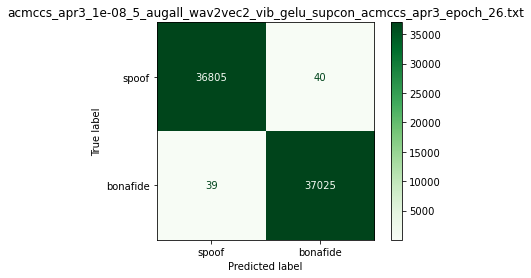

In [7]:
pred_df = pd.read_csv("docs/acmccs_apr3_1e-08_5_augall_wav2vec2_vib_gelu_supcon_acmccs_apr3_epoch_26.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("acmccs_apr3_1e-08_5_augall_wav2vec2_vib_gelu_supcon_acmccs_apr3_epoch_26.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [9]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df['group']=='SNS2024')]

,Unnamed: 0.1,path,Utterence name (file name),TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,...,Gender,Age,label,Model,subset,Unnamed: 0,type,spoof,score,pred
72199,90400,SNS/2024/VC_shahrukckhan_1.wav,VC_shahrukckhan_1.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_1,SNS2024,...,Male,Adult,spoof,-,eval,1511.0,-,-6.963834,-0.000946,bonafide
72438,90679,SNS/2024/VC_shahrukckhan_3.wav,VC_shahrukckhan_3.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_3,SNS2024,...,Male,Adult,spoof,-,eval,1790.0,-,-6.755858,-0.001165,bonafide
72664,90937,SNS/2024/VC_shahrukckhan_2.wav,VC_shahrukckhan_2.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_2,SNS2024,...,Male,Adult,spoof,-,eval,2048.0,-,-6.913900,-0.000994,bonafide
72814,91118,SNS/2024/VC_woman_1.wav,VC_woman_1.wav,-,-,English,-,https://youtube.com/watch?v=G1tHLs-UK90,VC_woman_1,SNS2024,...,Female,Adult,spoof,-,eval,2229.0,-,-6.965717,-0.000944,bonafide
72964,91293,SNS/2024/VC_shahrukckhan_5.wav,VC_shahrukckhan_5.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_5,SNS2024,...,Male,Adult,spoof,-,eval,2404.0,-,-6.841734,-0.001069,bonafide
73002,91336,SNS/2024/VC_woman_5.wav,VC_woman_5.wav,-,-,English,-,https://youtube.com/watch?v=G1tHLs-UK90,VC_woman_5,SNS2024,...,Female,Adult,spoof,-,eval,2447.0,-,-6.716797,-0.001211,bonafide
73727,92176,SNS/2024/TTS_Kim_joo_ha_5.wav,TTS_Kim_joo_ha_5.wav,-,-,Korean,Music,https://youtube.com/watch?v=nKESsnHxnp8,TTS_Kim_joo_ha_5,SNS2024,...,Female,Adult,spoof,-,eval,3290.0,-,-6.349235,-0.001750,bonafide
73796,92252,SNS/2024/TTS_Kim_joo_ha_4.wav,TTS_Kim_joo_ha_4.wav,-,-,Korean,Music,https://youtube.com/watch?v=nKESsnHxnp8,TTS_Kim_joo_ha_4,SNS2024,...,Female,Adult,spoof,-,eval,3366.0,-,-6.362487,-0.001727,bonafide


## Large_corpus Apr

In [11]:
large_corpus_apr_df = pd.read_csv("../traindata/0_large-corpus/meta_apr12.csv")
large_corpus_apr_df.fillna("-", inplace=True)
large_corpus_apr_df = large_corpus_apr_df.astype(str)
large_corpus_apr_df['Source link'] = large_corpus_apr_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)
large_corpus_apr_df['type'] = large_corpus_apr_df['Model'].apply(lambda x: "E2E" if "VITS" in x else x)


/tmp/ipykernel_12238/1321604341.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  large_corpus_apr_df = pd.read_csv("../traindata/0_large-corpus/meta_apr12.csv")


### large_apr12_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt

59506
59506
59506
False Positive
InWild - 11 - 0.2295%
DDDM-VC - 0 - 0.0000%
QuickVC - 1 - 0.0787%
AIHUB - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 4 - 0.1657%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 1 - 0.1406%
SNS2023 - 4 - 0.6061%
SNS2024 - 1 - 0.1656%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
False negative
InWild - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
QuickVC - 0 - 0.0000%
AIHUB - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
SNS2023 - 6 - 0.9091%
SNS2024 - 16 - 2.6490%
LibriSpeech - 4 - 0.0152%
VCTK - 2 - 0.0533%
Accuracy: 99.9160%


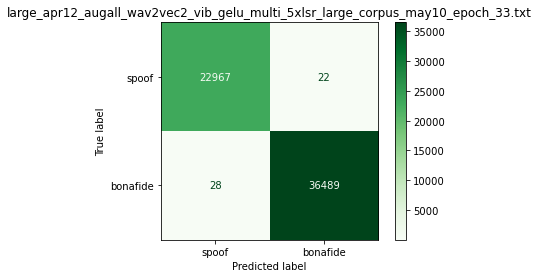

In [11]:
pred_df = pd.read_csv("docs/large_apr12_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_apr_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_apr12_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### large_corpus_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

59506
59506
Accuracy: 99.91%
Recall: 99.91%
Precision: 99.87%
F1: 99.89%
TP: 22969, TN: 36486, FP: 20, FN: 31
59506
EER: 0.0873%, threshold: -0.0003
Max, Min score:  -0.0001983445836231 -8.492898941040039
False Positive
InWild - 18 - 0.3756%
DDDM-VC - 0 - 0.0000%
QuickVC - 0 - 0.0000%
AIHUB - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
SNS2023 - 2 - 0.3030%
SNS2024 - 0 - 0.0000%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
False negative
InWild - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
QuickVC - 0 - 0.0000%
AIHUB - 1 - 0.0105%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StarGANv2-V

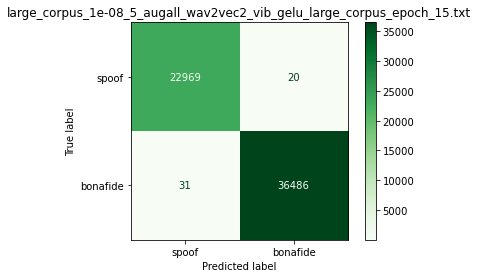

In [15]:
pred_df = pd.read_csv("docs/large_corpus_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[0][1], cm[1][0]))
# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_apr_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())


filter = 'group'
print("False Positive")
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_corpus_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [33]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df['group'].str.contains('SNS'))]

,Utterence name (file name),Speaker name,label,path,TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,...,Gender,Age,subset,Unnamed: 0.1,Model,Unnamed: 0,type,spoof,score,pred
8418,Morgan_Freeman_Singularity_5.wav,Morgan Freeman,spoof,SNS/2023/Morgan_Freeman_Singularity_5.wav,VC,No,English,Music,https://youtube.com/oxXpB9pSETo?si=qJXmXYz8ZSO...,Morgan_Freeman_Singularity_5,...,Male,Adult,dev,149156.0,-,563.0,-,-8.384110,-0.000228,bonafide
59379,Howtomake_AIcover_8.wav,TTS,spoof,SNS/2023/Howtomake_AIcover_8.wav,TTS,No,Korean,Music,https://youtube.com/PWQVcYml2ZA?si=ISO1e3aqKGO...,Howtomake_AIcover_8,...,Male,Adult,eval,72730.0,-,2371.0,-,-6.588956,-0.001376,bonafide
59390,Morgan_Freeman_Singularity_2.wav,Morgan Freeman,spoof,SNS/2023/Morgan_Freeman_Singularity_2.wav,VC,No,English,Music,https://youtube.com/oxXpB9pSETo?si=qJXmXYz8ZSO...,Morgan_Freeman_Singularity_2,...,Male,Adult,eval,72750.0,-,2443.0,-,-8.307013,-0.000247,bonafide


## Large corpus may10

In [3]:
large_corpus_may_df = pd.read_csv("../traindata/0_large-corpus/meta_may10.csv")
large_corpus_may_df.fillna("-", inplace=True)
large_corpus_may_df = large_corpus_may_df.astype(str)
large_corpus_may_df['Source link'] = large_corpus_may_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)
large_corpus_may_df['type'] = large_corpus_may_df['Model'].apply(lambda x: "E2E" if "VITS" in x else x)


/tmp/ipykernel_34790/3231507534.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  large_corpus_may_df = pd.read_csv("../traindata/0_large-corpus/meta_may10.csv")


### large_may10_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt

73074
73074
73074
False Positive
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
AIHUB - 3 - 0.0223%
SNS2023 - 19 - 1.8981%
SNS2024 - 5 - 0.7899%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 15 - 0.3091%
VITS-TTS - 11 - 0.3313%
DiffGAN - 0 - 0.0000%
VITS-VC - 1 - 0.0417%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 5 - 0.3514%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
False negative
LibriSpeech - 2 - 0.0076%
VCTK - 0 - 0.0000%
AIHUB - 0 - 0.0000%
SNS2023 - 2 - 0.1998%
SNS2024 - 6 - 0.9479%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
Accuracy: 99.9056%


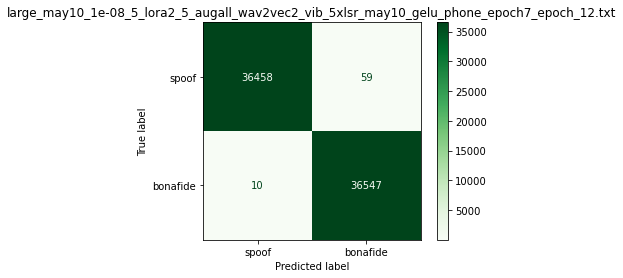

In [7]:
pred_df = pd.read_csv("docs/large_may10_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may10_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### large_may10_lora_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_regex_epoch_11.txt

73074
73074
73074
False Positive
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
AIHUB - 3 - 0.0223%
SNS2023 - 19 - 1.8981%
SNS2024 - 5 - 0.7899%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 15 - 0.3091%
VITS-TTS - 11 - 0.3313%
DiffGAN - 0 - 0.0000%
VITS-VC - 1 - 0.0417%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 5 - 0.3514%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
False negative
LibriSpeech - 2 - 0.0076%
VCTK - 0 - 0.0000%
AIHUB - 0 - 0.0000%
SNS2023 - 2 - 0.1998%
SNS2024 - 6 - 0.9479%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
Accuracy: 99.9056%


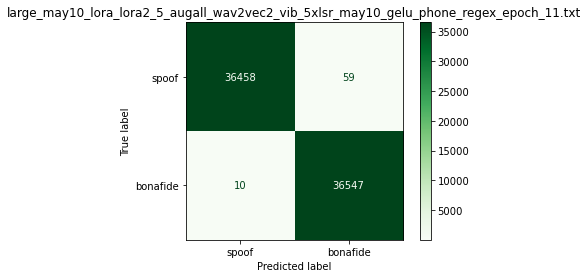

In [4]:
pred_df = pd.read_csv("docs/large_may10_lora_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_regex_epoch_11.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may10_lora_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_regex_epoch_11.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### large_may10_1e-08_5_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt

73074
73074
73074
False Positive
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
AIHUB - 2 - 0.0148%
SNS2023 - 6 - 0.5994%
SNS2024 - 4 - 0.6319%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 7 - 0.1442%
VITS-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 1 - 0.0417%
OpenVoice - 1 - 0.0475%
Elevenlabs - 1 - 0.0254%
DDDM-VC - 0 - 0.0000%
MMSTTS - 1 - 0.0703%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
False negative
LibriSpeech - 4 - 0.0152%
VCTK - 2 - 0.0533%
AIHUB - 0 - 0.0000%
SNS2023 - 6 - 0.5994%
SNS2024 - 16 - 2.5276%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
Accuracy: 99.9302%


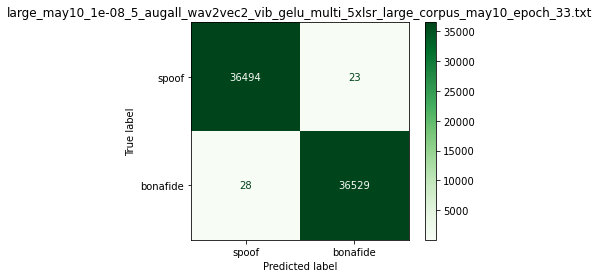

In [5]:
pred_df = pd.read_csv("docs/large_may10_1e-08_5_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may10_1e-08_5_augall_wav2vec2_vib_gelu_multi_5xlsr_large_corpus_may10_epoch_33.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### large_may10_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt

73074
73074
73074
False Positive
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
AIHUB - 3 - 0.0223%
SNS2023 - 19 - 1.8981%
SNS2024 - 5 - 0.7899%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 15 - 0.3091%
VITS-TTS - 11 - 0.3313%
DiffGAN - 0 - 0.0000%
VITS-VC - 1 - 0.0417%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 5 - 0.3514%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
False negative
LibriSpeech - 2 - 0.0076%
VCTK - 0 - 0.0000%
AIHUB - 0 - 0.0000%
SNS2023 - 2 - 0.1998%
SNS2024 - 6 - 0.9479%
SeamlessM4T-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
Accuracy: 99.9056%


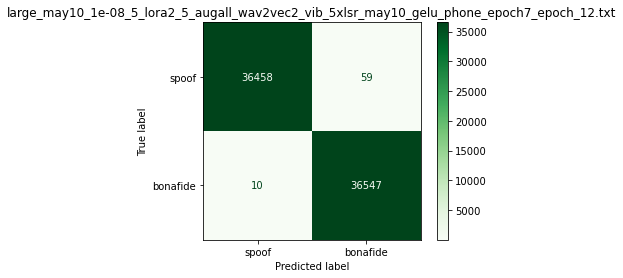

In [6]:
pred_df = pd.read_csv("docs/large_may10_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may10_1e-08_5_lora2_5_augall_wav2vec2_vib_5xlsr_may10_gelu_phone_epoch7_epoch_12.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### large_may10_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt

59546
59546
59546
False Positive
InWild - 15 - 0.3167%
Elevenlabs - 1 - 0.0513%
Tortoise-TTS - 5 - 0.2052%
AIHUB - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
VITS-TTS - 1 - 0.0604%
DiffGAN - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 1 - 0.1397%
Diff-HierVC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2023 - 9 - 1.4354%
SNS2024 - 3 - 0.5025%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
False negative
InWild - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
AIHUB - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2023 - 4 - 0.6380%
SNS2024 - 9 - 1.5075%
LibriSpeech - 4 - 0.0152%
VCTK - 0 - 0.0000%
LJSpeech - 1 - 2.5000%
Accuracy: 99.91

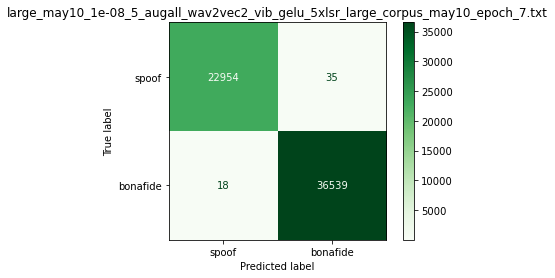

In [35]:
pred_df = pd.read_csv("docs/large_may10_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may10_1e-08_5_augall_wav2vec2_vib_gelu_5xlsr_large_corpus_may10_epoch_7.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [36]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df['group'].str.contains('SNS'))]

,Utterence name (file name),Speaker name,label,path,TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,...,Gender,Age,subset,Unnamed: 0.1,Model,Unnamed: 0,type,spoof,score,pred
6530,pride_and_prejudice_maleAI_5.wav,TTS_MALE,spoof,SNS/2023/pride_and_prejudice_maleAI_5.wav,TTS,No,English,-,Text to Speech Program,pride_and_prejudice_maleAI_5,...,Male,Adult,train,148703.0,-,110.0,-,-1.098983,-0.405280,bonafide
8393,pride_and_prejudice_maleAI_10.wav,TTS_MALE,spoof,SNS/2023/pride_and_prejudice_maleAI_10.wav,TTS,No,English,-,Text to Speech Program,pride_and_prejudice_maleAI_10,...,Male,Adult,dev,149010.0,-,417.0,-,-4.721543,-0.008941,bonafide
8409,todayistoday_2.wav,TTS_todayistoday,spoof,SNS/2023/todayistoday_2.wav,TTS,No,Korean,-,https://youtube.com/watch?v=jR2VnNH1Zek,todayistoday_2,...,Female,Adult,dev,149184.0,-,591.0,-,-3.679772,-0.025552,bonafide
59238,KwonEunBi_9.wav,TTS_Human_Addict,spoof,SNS/2023/KwonEunBi_9.wav,TTS,No,Korean,Music,https://youtube.com/Bxmnp2fzf4g?si=8lKrCLJqyPp...,KwonEunBi_9,...,Female,Adult,eval,72290.0,-,763.0,-,-7.541447,-0.000531,bonafide
59287,2022_01_21_AI_YOON_4.wav,YOON SUKYOUL,spoof,SNS/2023/2022_01_21_AI_YOON_4.wav,TTS,No,Korean,-,https://youtube.com/watch?v=KUNWa5UjxSg,2022_01_21_AI_YOON_4,...,Male,Adult,eval,72443.0,-,1275.0,-,-4.475754,-0.011447,bonafide
59306,VC_shahrukckhan_1.wav,shahrukckhan,spoof,SNS/2024/VC_shahrukckhan_1.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_1,...,Male,Adult,eval,72500.0,-,1511.0,-,-5.805868,-0.003014,bonafide
59352,ISU_AIcover_snowflower_4.wav,Isu,spoof,SNS/2023/ISU_AIcover_snowflower_4.wav,VC,No,Korean,Music,https://youtube.com/watch?v=ZJ5WnjoWSxU,ISU_AIcover_snowflower_4,...,Male,Adult,eval,72634.0,-,2003.0,-,-0.797581,-0.598595,bonafide
59413,VC_fofamit_1.wav,girl,spoof,SNS/2024/VC_fofamit_1.wav,-,-,English,Music,https://youtube.com/watch?v=aVfoC1EHlVs,VC_fofamit_1,...,Female,Teenager,eval,72798.0,-,2674.0,-,-2.168266,-0.121463,bonafide
59427,wonder0603_3.wav,TTS_wonder0603,spoof,SNS/2023/wonder0603_3.wav,TTS,No,Korean,-,https://youtube.com/watch?v=0RamuqXOhtA,wonder0603_3,...,Female,Adult,eval,72828.0,-,2776.0,-,-7.400931,-0.000611,bonafide
59431,VC_fofamit_4.wav,girl,spoof,SNS/2024/VC_fofamit_4.wav,-,-,English,Music,https://youtube.com/watch?v=aVfoC1EHlVs,VC_fofamit_4,...,Female,Teenager,eval,72854.0,-,2876.0,-,-4.832650,-0.007997,bonafide


## Large-corpus may16

In [2]:
large_corpus_may_df = pd.read_csv("../traindata/0_large-corpus/meta_may16.csv")
large_corpus_may_df.fillna("-", inplace=True)
large_corpus_may_df = large_corpus_may_df.astype(str)
large_corpus_may_df['Source link'] = large_corpus_may_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)
large_corpus_may_df['type'] = large_corpus_may_df['Model'].apply(lambda x: "E2E" if "VITS" in x else x)


### large_may16_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt

89898
89898
Accuracy: 99.93%
Recall: 99.92%
Precision: 99.89%
F1: 99.91%
TP: 32754, TN: 57082, FP: 35, FN: 27
89898
EER: 0.0677%, threshold: -0.2275
Max, Min score:  -0.0006175517919473 -7.4714555740356445
False Positive
InWild - 7 - 0.1487%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 3 - 0.1264%
VITS-TTS - 3 - 0.1858%
DDDM-VC - 0 - 0.0000%
AIHUB - 1 - 0.0104%
VITS-VC - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 1 - 0.0941%
Diff-HierVC - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
MMSTTS - 1 - 0.1379%
DiffGAN - 0 - 0.0000%
SNS2023 - 6 - 0.9091%
SNS2024 - 0 - 0.0000%
ASVspoof2019 - 1 - 0.0103%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
CommonVoice - 0 - 0.0000%
False negative
InWild - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
AIHUB - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
Di

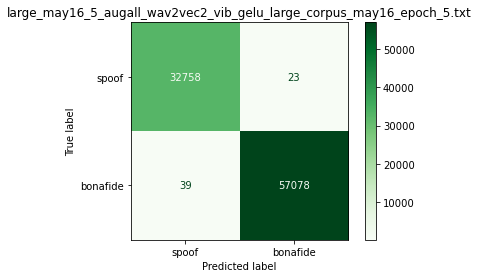

In [3]:
pred_df = pd.read_csv("docs/large_may16_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')

print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))

print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may16_5_augall_wav2vec2_vib_gelu_large_corpus_may16_epoch_5.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

### large_may16_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

89898
89898
Accuracy: 95.67%
Recall: 99.75%
Precision: 89.56%
F1: 94.38%
TP: 32700, TN: 53307, FP: 3810, FN: 81
89898
EER: 1.8511%, threshold: -8.1326
Max, Min score:  -0.0001948881981661 -8.523813247680664
False Positive
InWild - 61 - 1.2954%
Elevenlabs - 11 - 0.5281%
Tortoise-TTS - 23 - 0.9692%
VITS-TTS - 12 - 0.7430%
DDDM-VC - 6 - 0.7732%
AIHUB - 24 - 0.2507%
VITS-VC - 10 - 0.8396%
SeamlessM4T-TTS - 3 - 0.3264%
StarGANv2-VC - 2 - 0.1653%
OpenVoice - 6 - 0.5644%
Diff-HierVC - 5 - 0.6180%
StyleTTS2 - 6 - 1.0381%
MeloTTS - 0 - 0.0000%
MMSTTS - 4 - 0.5517%
DiffGAN - 10 - 5.0000%
SNS2023 - 14 - 2.1212%
SNS2024 - 3 - 0.5068%
ASVspoof2019 - 408 - 4.2097%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
LJSpeech - 0 - 0.0000%
CommonVoice - 0 - 0.0000%
False negative
InWild - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
AIHUB - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 -

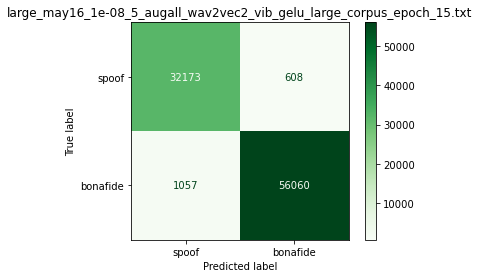

In [45]:
pred_df = pd.read_csv("docs/large_may16_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_may_df, pred_df, on='utt')

print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="spoof")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="spoof")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))

print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_may16_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## ASVspoof5

In [3]:
train_df = pd.read_csv('/dataa/phucdt/asvspoof5/DATA/ASVspoof5/ASVspoof5.train.metadata.txt', sep=' ', names=['spid', 'utt', 'gender', 'codec', 'attack', 'label'])
train_df['subset']='train'
dev_df = pd.read_csv('/dataa/phucdt/asvspoof5/DATA/ASVspoof5/ASVspoof5.dev.metadata.txt', sep=' ', names=['spid', 'utt', 'gender', 'codec', 'attack', 'label'])
dev_df['subset']='dev'
full_df = pd.concat([train_df, dev_df])

### asvspoof5_may16_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

323307
323307
Accuracy: 99.79%
Recall: 99.34%
Precision: 98.64%
F1: 98.98%
TP: 18672, TN: 163302, FP: 258, FN: 125
182357
False Positive
A05 - 7 - 0.0342%
A07 - 0 - 0.0000%
A04 - 20 - 0.0978%
A08 - 215 - 1.0516%
A02 - 0 - 0.0000%
A03 - 0 - 0.0000%
A06 - 14 - 0.0685%
bonafide - 0 - 0.0000%
A01 - 2 - 0.0098%
False negative
A05 - 0 - 0.0000%
A07 - 0 - 0.0000%
A04 - 0 - 0.0000%
A08 - 0 - 0.0000%
A02 - 0 - 0.0000%
A03 - 0 - 0.0000%
A06 - 0 - 0.0000%
bonafide - 125 - 0.6650%
A01 - 0 - 0.0000%


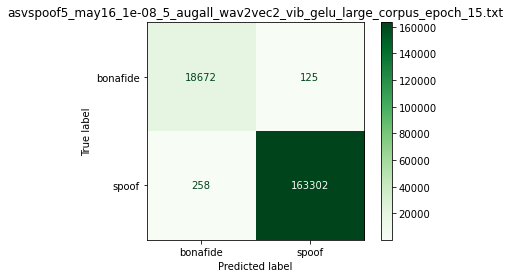

In [8]:
pred_df = pd.read_csv("docs/asvspoof5_may16_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(full_df, pred_df, on='utt')
res_df = res_df[res_df['subset'] == 'train']
print("Accuracy: {:.2f}%\nRecall: {:.2f}%\nPrecision: {:.2f}%\nF1: {:.2f}%".format(
            accuracy_score(res_df["label"], res_df["pred"])*100,
            recall_score(res_df["label"], res_df["pred"], pos_label="bonafide")*100, 
            precision_score(res_df["label"], res_df["pred"], pos_label="bonafide")*100, 
            f1_score(res_df["label"], res_df["pred"], pos_label="bonafide")*100))
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["bonafide","spoof"])
print("TP: {}, TN: {}, FP: {}, FN: {}".format(cm[0][0], cm[1][1], cm[1][0], cm[0][1]))

print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
# print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'attack'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["bonafide","spoof"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bonafide","spoof"])
disp.plot(cmap='Greens', values_format='g')
plt.title("asvspoof5_may16_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()